In [1]:
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

### Load TFDIF Vectorizer and Document Term Matrix from previous notebook

In [2]:
tfidf_vectorizer = joblib.load('pickled_files/tfidf_vectorizer')
document_term_matrix_sps = joblib.load('pickled_files/document_term_matrix_sps')
df = joblib.load('pickled_files/df')

In [3]:
document_term_matrix_df = pd.DataFrame(document_term_matrix_sps.toarray(),
                                       index=df.index,
                                       columns=tfidf_vectorizer.get_feature_names())

### Compute SVD of Document Term Matrix

$$\text{Latent Semantic Analysis} = \text{Document Term Matrix} + \text{SVD}$$

In [4]:
from sklearn.decomposition import TruncatedSVD

In [5]:
n_components=1500
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [6]:
svd_matrix = SVD.fit_transform(document_term_matrix_sps)

In [7]:
sum(SVD.explained_variance_ratio_)

0.74254748907920154

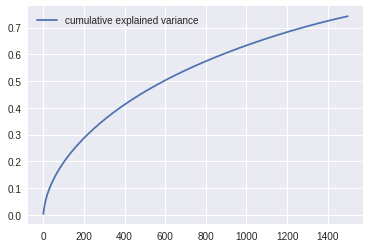

In [8]:
plt.plot(range(1500), np.cumsum(SVD.explained_variance_ratio_), label='cumulative explained variance')
plt.legend()

In [9]:
SVD.components_.shape

(1500, 28073)

### Cosine Similarities

The cosine similarity between two vectors (or two documents on the Vector Space) is a measure that calculates the cosine of the angle between them. This metric is a measurement of orientation and not magnitude, it can be seen as a comparison between documents on a normalized space because we’re not taking into the consideration only the magnitude of each word count (tf-idf) of each document, but the angle between the documents.

This is different from measuring Euclidian distances because distances would be measuring magnitude whereas we are looking at the direction of the documents. For example, we have a document with the word “machine learning” appearing 200 times and another document with the word “machine learning” appearing 50, the Euclidean distance between them will be higher but the angle will still be small because they are pointing to the same direction, which is what matters when we are comparing documents.

Cosine Similarity will generate a metric that says how related two documents are by looking at the angle instead of magnitude, like in the examples below:

![cosine_similarity](https://raw.githubusercontent.com/michaelkim9/wikipedia_search_engine_nlp/master/other_assets/cosinesimilarity.png)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
search_term = 'Random Forest'
search_term_tfidf_matrix = tfidf_vectorizer.transform([search_term])
search_term_lsa = SVD.transform(search_term_tfidf_matrix)

In [12]:
cos_sim = cosine_similarity(search_term_lsa, svd_matrix)

In [13]:
cos_df = pd.DataFrame(cos_sim, columns=df.page_title).T
cos_df.reset_index(inplace=True)
cos_df.drop_duplicates(subset=['page_title'],inplace=True)
cos_df.set_index('page_title',inplace=True)
cos_df.columns = ['score']
cos_df.sort_values('score',ascending=False).head()

,score
page_title,
Random forest,0.816338
Jackknife variance estimates for random forest,0.775225
Kernel random forest,0.767955
Random indexing,0.410654
Random projection,0.378585


### Search Function for Cosine Similarities

Looks like the search above on cosine similarities works pretty well! Now going create function for it and I'll build a little more funcationality by bringing in the page summary and link to the page url. The function will return the top 5 search results. Will demonstrate with a few examples below.

In [14]:
def wikipedia_search(search_term):
    search_term_tfidf_matrix = tfidf_vectorizer.transform([search_term])
    search_term_lsa = SVD.transform(search_term_tfidf_matrix)
    cos_sim = cosine_similarity(search_term_lsa, svd_matrix)
    cos_df = pd.DataFrame(cos_sim, columns=df.page_title).T
    search_df = df[['page_title','page_summary','page_url']]
    cos_df.reset_index(inplace=True)
    cos_df = pd.merge(cos_df,search_df, on='page_title',how='left', indicator=True)
    cos_df.drop_duplicates(subset=['page_title'],inplace=True)
    cos_df.set_index('page_title',inplace=True)
    cos_df.columns = ['score','page_summary','page_url','merge']
    cos_df.drop(['merge'],axis=1, inplace=True)
    return cos_df.sort_values('score',ascending=False).head()

In [15]:
wikipedia_search('Random Forest')

,score,page_summary,page_url
page_title,,,
Random forest,0.816338,Random forests or random decision forests are ...,https://en.wikipedia.org/wiki/Random_forest
Jackknife variance estimates for random forest,0.775225,"In statistics, jackknife variance estimates fo...",https://en.wikipedia.org/wiki/Jackknife_varian...
Kernel random forest,0.767955,"In machine learning, kernel random forests est...",https://en.wikipedia.org/wiki/Kernel_random_fo...
Random indexing,0.410654,Random indexing is a dimension reduction metho...,https://en.wikipedia.org/wiki/Random_indexing
Random projection,0.378585,"In mathematics and statistics, random projecti...",https://en.wikipedia.org/wiki/Random_projection


In [16]:
wikipedia_search('Skype')

,score,page_summary,page_url
page_title,,,
Skype for Business,0.705727,Skype for Business (formerly Microsoft Office ...,https://en.wikipedia.org/wiki/Skype_for_Business
Outlook.com,0.356843,"Outlook.com is a web-based suite of webmail, c...",https://en.wikipedia.org/wiki/Outlook.com
Symphony Communication,0.311220,"Symphony is a secure, cloud-based, communicati...",https://en.wikipedia.org/wiki/Symphony_Communi...
Microsoft Office Live Meeting,0.302471,Microsoft Office Live Meeting is a discontinue...,https://en.wikipedia.org/wiki/Microsoft_Office...
Zingaya,0.297904,Zingaya was launched in North America on Septe...,https://en.wikipedia.org/wiki/Zingaya


In [17]:
wikipedia_search('Perceptron')

,score,page_summary,page_url
page_title,,,
Multilayer perceptron,0.679771,A multilayer perceptron (MLP) is a class of fe...,https://en.wikipedia.org/wiki/Multilayer_perce...
Perceptron,0.577002,"In machine learning, the perceptron is an algo...",https://en.wikipedia.org/wiki/Perceptron
Kernel perceptron,0.407601,"In machine learning, the kernel perceptron is ...",https://en.wikipedia.org/wiki/Kernel_perceptron
ADALINE,0.342421,ADALINE (Adaptive Linear Neuron or later Adapt...,https://en.wikipedia.org/wiki/ADALINE
Winnow (algorithm),0.322537,The winnow algorithm is a technique from machi...,https://en.wikipedia.org/wiki/Winnow_(algorithm)


In [18]:
wikipedia_search('coefficient')

,score,page_summary,page_url
page_title,,,
Matthews correlation coefficient,0.731489,The Matthews correlation coefficient is used i...,https://en.wikipedia.org/wiki/Matthews_correla...
Congruence coefficient,0.673572,"In multivariate statistics, the congruence coe...",https://en.wikipedia.org/wiki/Congruence_coeff...
Path coefficient,0.656224,Path coefficients are standardized versions of...,https://en.wikipedia.org/wiki/Path_coefficient
Jaccard index,0.548367,"The Jaccard index, also known as Intersection ...",https://en.wikipedia.org/wiki/Jaccard_index
Linear predictor function,0.494813,"In statistics and in machine learning, a linea...",https://en.wikipedia.org/wiki/Linear_predictor...


In [19]:
wikipedia_search('Microsoft')

,score,page_summary,page_url
page_title,,,
Microsoft Visio,0.752705,Microsoft Visio ( VIZ-ee-oh) (formerly Microso...,https://en.wikipedia.org/wiki/Microsoft_Visio
Microsoft PhotoDraw,0.668129,Microsoft PhotoDraw 2000 is a discontinued vec...,https://en.wikipedia.org/wiki/Microsoft_PhotoDraw
Microsoft FrontPage,0.664720,Microsoft FrontPage (full name Microsoft Offic...,https://en.wikipedia.org/wiki/Microsoft_FrontPage
Microsoft FRx,0.659392,Microsoft FRx is a software product used for f...,https://en.wikipedia.org/wiki/Microsoft_FRx
Microsoft Office 3.0,0.657555,Microsoft Office 3.0 was the second major rele...,https://en.wikipedia.org/wiki/Microsoft_Office...
